Exploratory Data Analysis of the main features of the data and check the relationsships that hold between the variables and see which variables are important for our problem.

In [1]:
import pandas as pd
import mysql.connector
import os as os

connection_params = {
    'host': 'localhost',
    'user': 'admin',
    'password': 'Criminal1234',
    'database': 'CriminalDataDB',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**connection_params)
cursor = conn.cursor()

query = """SELECT * FROM Bevoelkerungsdichte bd 
            JOIN Bevoelkerungsdaten bvd ON bd.Gemeindename = bvd.Gemeindename  
            AND bd.Jahr = bvd.Jahr JOIN Einkommensdaten ed ON bd.BFS_NR = ed.BFS_NR 
            AND bd.Gemeindename = ed.Gemeindename 
            AND bd.Jahr = ed.Jahr JOIN Finanzvermoegen fv ON bd.BFS_NR = fv.BFS_NR 
            AND bd.Gemeindename = fv.Gemeindename AND bd.Jahr = fv.Jahr JOIN Einbrueche en ON bd.BFS_NR = en.BFS_NR 
            AND bd.Gemeindename = en.Gemeindename AND bd.Jahr = en.Jahr"""
cursor.execute(query)

results = cursor.fetchall()
columns = [i[0] for i in cursor.description]
df = pd.DataFrame(results, columns=columns)

cursor.close()
conn.close()

duplicated_columns = ['Gemeindename', 'Jahr', 'BFS_NR']

df_unique = df.loc[:, ~df.columns.duplicated()]
print(df_unique)

      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0          1       Aeugst  2010                           231.5   
1          2    Affoltern  2010                          1043.7   
2          3   Bonstetten  2010                           693.2   
3          4       Hausen  2010                           245.8   
4          5     Hedingen  2010                           521.9   
...      ...          ...   ...                             ...   
2208     243     Dietikon  2018                          2925.2   
2209     244   Geroldswil  2018                          2601.1   
2210     230   Winterthur  2019                          1657.5   
2211     227      Seuzach  2020                           976.6   
2212     228   Turbenthal  2022                           199.6   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                          281                        263   
1                         1688                       2283   
2           

Zürich Daten summieren da für mehrere Kreise mehrere Einträge für Zürich vorhanden sind.

In [2]:
zurich_data = df_unique[df_unique['Gemeindename'] == 'Zürich']

zurich_summed = zurich_data.groupby(['Jahr']).agg({
    'Einbruchdiebstahl_Total': 'sum',
    'Einschleichdiebstahl_Total': 'sum',
    'Einbruchdiebstahl_Versucht': 'sum',
    'Einschleichdiebstahl_Versucht': 'sum',
    'Einbruchdiebstahl_Vollendet': 'sum',
    'Einschleichdiebstahl_Vollendet': 'sum',
    'BFS_NR': 'first',
    'Gemeindename': 'first',
    'Einwohner_pro_Quadratkilometer': 'first',
    'Einwohner 0-14 Jahre alt': 'first',
    'Einwohner 15-29 Jahre alt': 'first',
    'Einwohner 30-44 Jahre alt': 'first',
    'Einwohner 45-59 Jahre alt': 'first',
    'Einwohner 60-74 Jahre alt': 'first',
    'Einwohner 75-89 Jahre alt': 'first',
    'Einwohner 90-104 Jahre alt': 'first',
    'durchschnittliches_steuerbares_Einkommen_pro_Einwohner': 'first',
    'Finanzvermoegen_pro_Einwohner': 'first',
    'Einwohner': 'sum'
}).reset_index()

df_unique = df_unique[df_unique['Gemeindename'] != 'Zürich']  # Vorhandene Zürich-Zeilen entfernen
df_unique = pd.concat([df_unique, zurich_summed], ignore_index=True)  # Summierte Zeilen hinzufügen
print(df_unique)

      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0          1       Aeugst  2010                           231.5   
1          2    Affoltern  2010                          1043.7   
2          3   Bonstetten  2010                           693.2   
3          4       Hausen  2010                           245.8   
4          5     Hedingen  2010                           521.9   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                          281                        263   
1                         1688                       2283   
2           

In [3]:
directory = 'Cleaned_CSV_files'
current_directory = os.getcwd()

csv_path = os.path.join(current_directory, directory, 'EDA.csv')

if not os.path.exists(os.path.join(current_directory, directory)):
    os.makedirs(os.path.join(current_directory, directory))

df_unique.to_csv(csv_path, index=False)
print(df_unique)

      BFS_NR Gemeindename  Jahr  Einwohner_pro_Quadratkilometer  \
0          1       Aeugst  2010                           231.5   
1          2    Affoltern  2010                          1043.7   
2          3   Bonstetten  2010                           693.2   
3          4       Hausen  2010                           245.8   
4          5     Hedingen  2010                           521.9   
...      ...          ...   ...                             ...   
2054     261       Zürich  2018                          4707.8   
2055     261       Zürich  2019                          4765.8   
2056     261       Zürich  2020                          4787.2   
2057     261       Zürich  2021                          4802.1   
2058     261       Zürich  2022                          4855.4   

      Einwohner 0-14 Jahre alt  Einwohner 15-29 Jahre alt  \
0                          281                        263   
1                         1688                       2283   
2           

Check data types and related information, such as the quantity of records in each column, whether the data is null, the type of data

### Quantiles

In [4]:
df_unique[['Einbruchdiebstahl_Total','Einschleichdiebstahl_Total','Einbruchdiebstahl_Versucht','Einschleichdiebstahl_Versucht','Einbruchdiebstahl_Vollendet','Einschleichdiebstahl_Vollendet','BFS_NR','Einwohner_pro_Quadratkilometer','Einwohner 0-14 Jahre alt','Einwohner 15-29 Jahre alt','Einwohner 30-44 Jahre alt','Einwohner 45-59 Jahre alt','Einwohner 60-74 Jahre alt','Einwohner 75-89 Jahre alt','Einwohner 90-104 Jahre alt','durchschnittliches_steuerbares_Einkommen_pro_Einwohner','Finanzvermoegen_pro_Einwohner','Einwohner']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]).round(2)

,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet,BFS_NR,Einwohner_pro_Quadratkilometer,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner
0.05,0.0,0.0,0.0,0.0,0.0,0.0,8.0,102.70,104.0,97.0,132.0,170.9,112.0,39.0,2.9,52411.8,3763.9,657.8
0.10,1.0,0.0,0.0,0.0,0.0,0.0,24.0,128.58,156.0,134.0,192.8,234.0,141.8,51.8,4.0,54863.8,4296.6,921.8
0.25,4.0,1.0,1.0,0.0,2.0,1.0,59.0,236.20,287.5,298.0,365.0,479.0,295.5,114.0,9.0,59349.5,5294.0,1910.5
0.50,12.0,3.0,5.0,0.0,7.0,3.0,115.0,537.50,688.0,668.0,885.0,1047.0,694.0,265.0,22.0,65390.0,7087.0,4261.0
0.75,30.0,8.0,12.0,1.0,18.0,8.0,197.0,1019.80,1239.0,1301.0,1705.0,1819.0,1237.5,631.0,59.0,72948.0,9494.0,7874.0
0.90,66.2,19.0,27.0,1.0,39.0,18.0,244.0,1842.76,2527.4,2814.2,4070.4,3543.0,2416.8,1285.4,123.0,88875.0,12736.2,16735.0
0.95,106.1,29.0,41.0,2.0,67.0,27.1,261.0,2520.26,3443.6,3819.5,5025.7,4552.9,3067.6,1690.0,183.1,114770.0,14952.1,21376.4


### Data types

In [5]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   BFS_NR                                                  2059 non-null   int64  
 1   Gemeindename                                            2059 non-null   object 
 2   Jahr                                                    2059 non-null   int64  
 3   Einwohner_pro_Quadratkilometer                          2059 non-null   float64
 4   Einwohner 0-14 Jahre alt                                2059 non-null   int64  
 5   Einwohner 15-29 Jahre alt                               2059 non-null   int64  
 6   Einwohner 30-44 Jahre alt                               2059 non-null   int64  
 7   Einwohner 45-59 Jahre alt                               2059 non-null   int64  
 8   Einwohner 60-74 Jahre alt             

### Summary statistics of numeric variables

In [6]:
df_unique.describe()

,BFS_NR,Jahr,Einwohner_pro_Quadratkilometer,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,127.915979,2016.009713,789.587275,1396.033997,1580.361340,2238.384653,2003.959689,1316.594949,679.841671,76.199611,70283.233609,7888.786790,9210.204954,46.879553,11.725109,18.149102,0.703254,28.730452,11.021855
std,82.856493,3.743852,789.373958,4498.122096,5850.538321,9590.552674,6357.337751,3933.568065,2354.834262,355.155557,22225.213635,3763.783248,32698.671533,272.026384,56.079253,104.162147,3.592975,168.514143,52.756560
min,1.000000,2010.000000,62.000000,58.000000,43.000000,56.000000,77.000000,26.000000,18.000000,0.000000,9634.000000,2067.000000,306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,2013.000000,236.200000,287.500000,298.000000,365.000000,479.000000,295.500000,114.000000,9.000000,59349.500000,5294.000000,1910.500000,4.000000,1.000000,1.000000,0.000000,2.000000,1.000000
50%,115.000000,2016.000000,537.500000,688.000000,668.000000,885.000000,1047.000000,694.000000,265.000000,22.000000,65390.000000,7087.000000,4261.000000,12.000000,3.000000,5.000000,0.000000,7.000000,3.000000
75%,197.000000,2019.000000,1019.800000,1239.000000,1301.000000,1705.000000,1819.000000,1237.500000,631.000000,59.000000,72948.000000,9494.000000,7874.000000,30.000000,8.000000,12.000000,1.000000,18.000000,8.000000
max,298.000000,2022.000000,4855.400000,59876.000000,75261.000000,127463.000000,83171.000000,48958.000000,30551.000000,4670.000000,581506.000000,45276.000000,423193.000000,6031.000000,815.000000,2166.000000,80.000000,3865.000000,773.000000


*Einwohner nach Alter*: Die Standardabweichung in diesen Spalten kann hoch sein, da die Altersverteilung von Gemeinde zu Gemeinde stark variieren kann. Einige Gemeinden könnten eine grosse Anzahl von Einwohnern in bestimmten Altersgruppen haben, während andere Gemeinden möglicherweise eine gleichmässigere Verteilung aufweisen. Weiters kann es in ländlichen Regionen vermehrt eher hohe Altersgruppen haben.

*durchschnittliches steuerbares Einkommen pro Einwohner, Finanzvermoegen_pro_Einwohner*: Diese Spalten könnten Ausreisser enthalten. Einige Gemeinden könnten aufgrund spezifischer wirtschaftlicher Bedingungen oder demografischer Merkmale ungewöhnlich hohe oder niedrige Einkommens- und Vermögenswerte aufweisen.

Es kann auch interessant sein, die Beziehung zwischen dem Alter der Einwohner und ihren Einkommens- oder Vermögensniveaus zu untersuchen. Ältere Einwohner haben oft höhere Einkommens- und Vermögenswerte aufgrund ihres langjährigen Berufslebens und ihrer Ersparnisse, während jüngere Einwohner möglicherweise niedrigere Einkommensniveaus aufweisen, aber auch das Potenzial für zukünftiges Einkommen haben.

Check if there are any empty values in the columns and how many unique values we can find within the table

In [7]:
df_unique.isnull().sum()    

BFS_NR                                                    0
Gemeindename                                              0
Jahr                                                      0
Einwohner_pro_Quadratkilometer                            0
Einwohner 0-14 Jahre alt                                  0
Einwohner 15-29 Jahre alt                                 0
Einwohner 30-44 Jahre alt                                 0
Einwohner 45-59 Jahre alt                                 0
Einwohner 60-74 Jahre alt                                 0
Einwohner 75-89 Jahre alt                                 0
Einwohner 90-104 Jahre alt                                0
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    0
Finanzvermoegen_pro_Einwohner                             0
Einwohner                                                 0
Einbruchdiebstahl_Total                                   0
Einschleichdiebstahl_Total                                0
Einbruchdiebstahl_Versucht              

In [8]:
df_unique.nunique()

BFS_NR                                                     159
Gemeindename                                               159
Jahr                                                        13
Einwohner_pro_Quadratkilometer                            1871
Einwohner 0-14 Jahre alt                                  1274
Einwohner 15-29 Jahre alt                                 1278
Einwohner 30-44 Jahre alt                                 1405
Einwohner 45-59 Jahre alt                                 1426
Einwohner 60-74 Jahre alt                                 1252
Einwohner 75-89 Jahre alt                                  940
Einwohner 90-104 Jahre alt                                 250
durchschnittliches_steuerbares_Einkommen_pro_Einwohner    2000
Finanzvermoegen_pro_Einwohner                             1867
Einwohner                                                 1840
Einbruchdiebstahl_Total                                    183
Einschleichdiebstahl_Total                             

### Covariance and Correlation Matrix

In [9]:
corr = df_unique[['Einbruchdiebstahl_Total','Einschleichdiebstahl_Total','Einbruchdiebstahl_Versucht','Einschleichdiebstahl_Versucht','Einbruchdiebstahl_Vollendet','Einschleichdiebstahl_Vollendet','BFS_NR','Einwohner_pro_Quadratkilometer','Einwohner 0-14 Jahre alt','Einwohner 15-29 Jahre alt','Einwohner 30-44 Jahre alt','Einwohner 45-59 Jahre alt','Einwohner 60-74 Jahre alt','Einwohner 75-89 Jahre alt','Einwohner 90-104 Jahre alt','durchschnittliches_steuerbares_Einkommen_pro_Einwohner','Finanzvermoegen_pro_Einwohner','Einwohner']].cov().corr()
corr

,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet,BFS_NR,Einwohner_pro_Quadratkilometer,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner
Einbruchdiebstahl_Total,1.000000,0.999967,0.999999,0.999987,1.000000,0.999962,0.957038,0.961117,0.999975,0.999885,0.999979,0.999979,0.999972,0.999901,0.999795,-0.203010,-0.058873,0.999982
Einschleichdiebstahl_Total,0.999967,1.000000,0.999957,0.999953,0.999972,1.000000,0.955141,0.959134,0.999982,0.999974,0.999995,0.999955,0.999934,0.999787,0.999627,-0.210291,-0.066499,0.999984
Einbruchdiebstahl_Versucht,0.999999,0.999957,1.000000,0.999991,0.999997,0.999952,0.957435,0.961505,0.999972,0.999866,0.999973,0.999983,0.999977,0.999920,0.999824,-0.201641,-0.057558,0.999980
Einschleichdiebstahl_Versucht,0.999987,0.999953,0.999991,1.000000,0.999983,0.999947,0.957804,0.961764,0.999981,0.999862,0.999976,0.999993,0.999989,0.999934,0.999842,-0.200943,-0.057315,0.999986
Einbruchdiebstahl_Vollendet,1.000000,0.999972,0.999997,0.999983,1.000000,0.999968,0.956785,0.960870,0.999975,0.999896,0.999981,0.999976,0.999967,0.999888,0.999775,-0.203877,-0.059706,0.999983
Einschleichdiebstahl_Vollendet,0.999962,1.000000,0.999952,0.999947,0.999968,1.000000,0.954966,0.958961,0.999979,0.999978,0.999994,0.999950,0.999927,0.999775,0.999610,-0.210892,-0.067090,0.999981
BFS_NR,0.957038,0.955141,0.957435,0.957804,0.956785,0.954966,1.000000,0.997644,0.956734,0.953378,0.955973,0.957870,0.958441,0.960918,0.962485,0.074320,0.190713,0.956754
Einwohner_pro_Quadratkilometer,0.961117,0.959134,0.961505,0.961764,0.960870,0.958961,0.997644,1.000000,0.960535,0.957278,0.959921,0.961663,0.962185,0.964725,0.966403,0.071506,0.202142,0.960610
Einwohner 0-14 Jahre alt,0.999975,0.999982,0.999972,0.999981,0.999975,0.999979,0.956734,0.960535,1.000000,0.999933,0.999994,0.999991,0.999981,0.999875,0.999739,-0.205729,-0.062592,0.999999
Einwohner 15-29 Jahre alt,0.999885,0.999974,0.999866,0.999862,0.999896,0.999978,0.953378,0.957278,0.999933,1.000000,0.999953,0.999877,0.999845,0.999629,0.999417,-0.216937,-0.073457,0.999929


In [10]:
cov = df[['Einbruchdiebstahl_Total','Einschleichdiebstahl_Total','Einbruchdiebstahl_Versucht','Einschleichdiebstahl_Versucht','Einbruchdiebstahl_Vollendet','Einschleichdiebstahl_Vollendet','BFS_NR','Einwohner_pro_Quadratkilometer','Einwohner 0-14 Jahre alt','Einwohner 15-29 Jahre alt','Einwohner 30-44 Jahre alt','Einwohner 45-59 Jahre alt','Einwohner 60-74 Jahre alt','Einwohner 75-89 Jahre alt','Einwohner 90-104 Jahre alt','durchschnittliches_steuerbares_Einkommen_pro_Einwohner','Finanzvermoegen_pro_Einwohner','Einwohner']].cov()
cov

,Einbruchdiebstahl_Total,Einschleichdiebstahl_Total,Einbruchdiebstahl_Versucht,Einschleichdiebstahl_Versucht,Einbruchdiebstahl_Vollendet,Einschleichdiebstahl_Vollendet,BFS_NR,BFS_NR,BFS_NR,BFS_NR,...,Einwohner 0-14 Jahre alt,Einwohner 15-29 Jahre alt,Einwohner 30-44 Jahre alt,Einwohner 45-59 Jahre alt,Einwohner 60-74 Jahre alt,Einwohner 75-89 Jahre alt,Einwohner 90-104 Jahre alt,durchschnittliches_steuerbares_Einkommen_pro_Einwohner,Finanzvermoegen_pro_Einwohner,Einwohner
Einbruchdiebstahl_Total,7.722790e+03,1605.630230,2962.489851,86.385265,4.760300e+03,1519.244966,2.933448e+03,2.933448e+03,2.933448e+03,2.933448e+03,...,8.658411e+05,1.155621e+06,1.888193e+06,1.243007e+06,7.754496e+05,4.736396e+05,6.975607e+04,-1.438568e+05,5.466406e+04,9.357917e+05
Einschleichdiebstahl_Total,1.605630e+03,420.371946,614.936759,22.917955,9.906935e+02,397.453990,6.549279e+02,6.549279e+02,6.549279e+02,6.549279e+02,...,1.888985e+05,2.475730e+05,4.044584e+05,2.677624e+05,1.657565e+05,9.936814e+04,1.485724e+04,-4.396928e+04,7.464636e+03,2.290695e+05
Einbruchdiebstahl_Versucht,2.962490e+03,614.936759,1168.749233,33.933946,1.793741e+03,581.002814,1.134443e+03,1.134443e+03,1.134443e+03,1.134443e+03,...,3.369191e+05,4.478441e+05,7.334637e+05,4.826013e+05,3.005047e+05,1.830774e+05,2.713841e+04,-5.160991e+04,2.093315e+04,3.638045e+05
Einschleichdiebstahl_Versucht,8.638526e+01,22.917955,33.933946,2.276922,5.245132e+01,20.641034,4.046587e+01,4.046587e+01,4.046587e+01,4.046587e+01,...,1.152768e+04,1.496801e+04,2.465148e+04,1.627661e+04,1.001154e+04,5.969349e+03,9.065643e+02,-1.675386e+03,4.834667e+02,1.317184e+04
Einbruchdiebstahl_Vollendet,4.760300e+03,990.693471,1793.740617,52.451319,2.966559e+03,938.242152,1.799005e+03,1.799005e+03,1.799005e+03,1.799005e+03,...,5.289220e+05,7.077772e+05,1.154729e+06,7.604061e+05,4.749449e+05,2.905621e+05,4.261765e+04,-9.224685e+04,3.373091e+04,5.719872e+05
Einschleichdiebstahl_Vollendet,1.519245e+03,397.453990,581.002814,20.641034,9.382422e+02,376.812957,6.144621e+02,6.144621e+02,6.144621e+02,6.144621e+02,...,1.773708e+05,2.326050e+05,3.798069e+05,2.514857e+05,1.557449e+05,9.339879e+04,1.395067e+04,-4.229389e+04,6.981170e+03,2.158977e+05
BFS_NR,2.933448e+03,654.927940,1134.442874,40.465872,1.799005e+03,614.462069,7.534503e+03,7.534503e+03,7.534503e+03,7.534503e+03,...,5.258090e+05,6.836530e+05,1.135622e+06,7.486252e+05,4.624672e+05,2.784263e+05,4.228828e+04,7.094700e+04,5.557286e+03,4.169262e+05
BFS_NR,2.933448e+03,654.927940,1134.442874,40.465872,1.799005e+03,614.462069,7.534503e+03,7.534503e+03,7.534503e+03,7.534503e+03,...,5.258090e+05,6.836530e+05,1.135622e+06,7.486252e+05,4.624672e+05,2.784263e+05,4.228828e+04,7.094700e+04,5.557286e+03,4.169262e+05
BFS_NR,2.933448e+03,654.927940,1134.442874,40.465872,1.799005e+03,614.462069,7.534503e+03,7.534503e+03,7.534503e+03,7.534503e+03,...,5.258090e+05,6.836530e+05,1.135622e+06,7.486252e+05,4.624672e+05,2.784263e+05,4.228828e+04,7.094700e+04,5.557286e+03,4.169262e+05
BFS_NR,2.933448e+03,654.927940,1134.442874,40.465872,1.799005e+03,614.462069,7.534503e+03,7.534503e+03,7.534503e+03,7.534503e+03,...,5.258090e+05,6.836530e+05,1.135622e+06,7.486252e+05,4.624672e+05,2.784263e+05,4.228828e+04,7.094700e+04,5.557286e+03,4.169262e+05



### Univariate Analysis & Multivariate graphical exploratory data analysis (EDA)
Boxplots für Einkommens- und Vermögensdaten: Boxplots für das durchschnittliche steuerpflichtige Einkommen pro Einwohner und das Finanzvermögen pro Einwohner, um die Verteilung und mögliche Ausreißer in diesen Daten zu visualisieren.
Zeitreihendiagramme für Einbrüche: Zeitreihendiagramme für Einbruchs- und Diebstahlsstatistiken im Laufe der Jahre bezogen auf die Top 5 Gemeinden

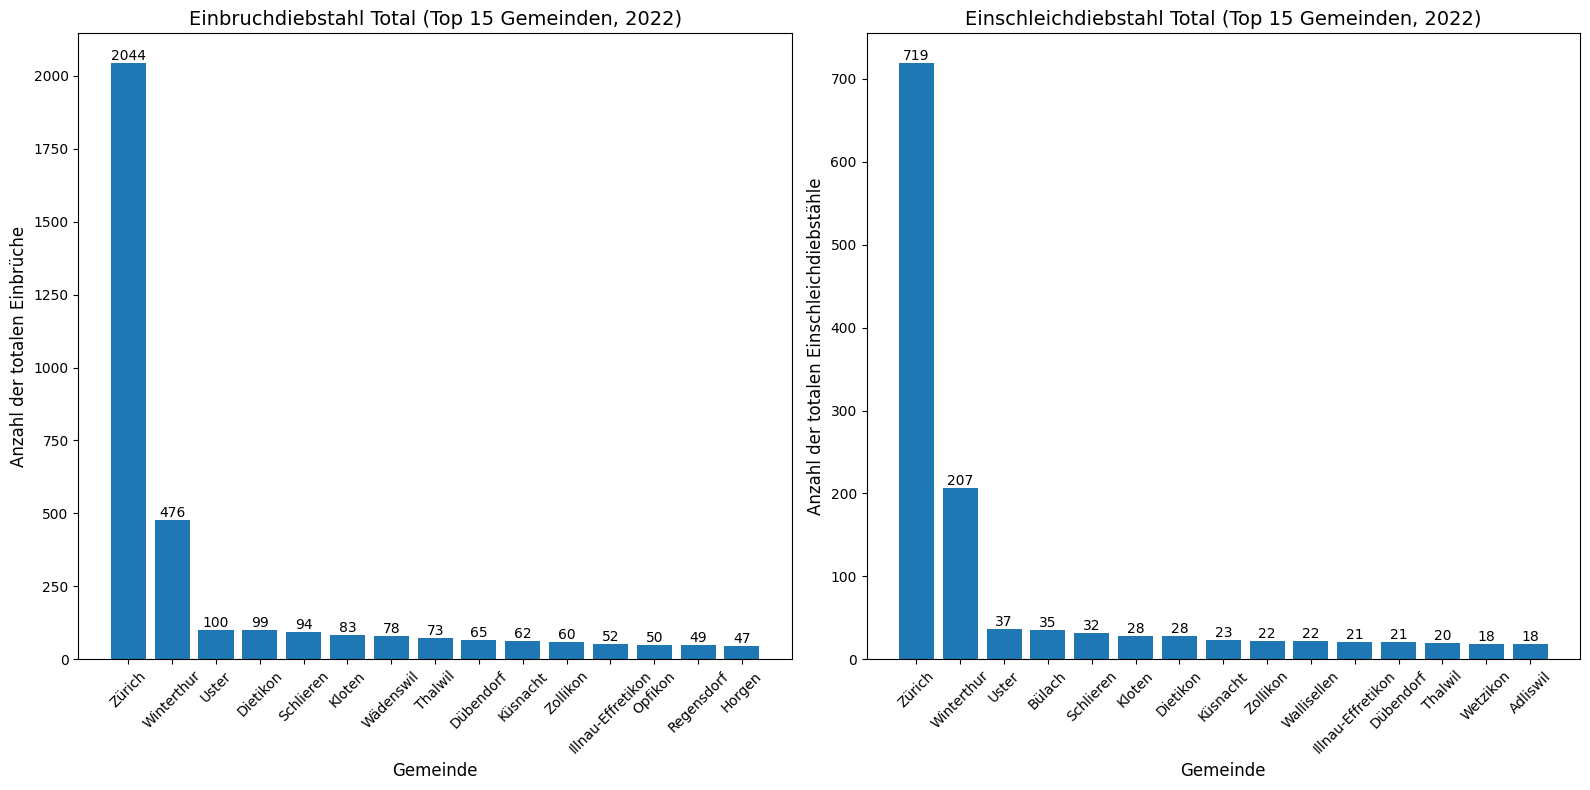

In [11]:
import matplotlib.pyplot as plt
df_2022 = df_unique[df_unique['Jahr'] == 2022]

# Sortieren nach Einbruchdiebstahl_Total und Einschleichdiebstahl_Total, um die Top 15 Gemeinden zu finden
df_sorted_by_einbruch = df_2022.sort_values(by='Einbruchdiebstahl_Total', ascending=False).head(15)
df_sorted_by_einschleich = df_2022.sort_values(by='Einschleichdiebstahl_Total', ascending=False).head(15)

top_einbruch_gemeinden = df_sorted_by_einbruch['Gemeindename']
top_einschleich_gemeinden = df_sorted_by_einschleich['Gemeindename']

plt.figure(figsize=(16, 8))  
plt.subplot(1, 2, 1)
bars1 = plt.bar(top_einbruch_gemeinden, df_sorted_by_einbruch['Einbruchdiebstahl_Total'])
plt.xlabel('Gemeinde', fontsize=12)  
plt.ylabel('Anzahl der totalen Einbrüche', fontsize=12)
plt.title('Einbruchdiebstahl Total (Top 15 Gemeinden, 2022)', fontsize=14) 
plt.xticks(rotation=45, fontsize=10) 

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars2 = plt.bar(top_einschleich_gemeinden, df_sorted_by_einschleich['Einschleichdiebstahl_Total'])
plt.xlabel('Gemeinde', fontsize=12)  
plt.ylabel('Anzahl der totalen Einschleichdiebstähle', fontsize=12)  
plt.title('Einschleichdiebstahl Total (Top 15 Gemeinden, 2022)', fontsize=14)  
plt.xticks(rotation=45, fontsize=10)  
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

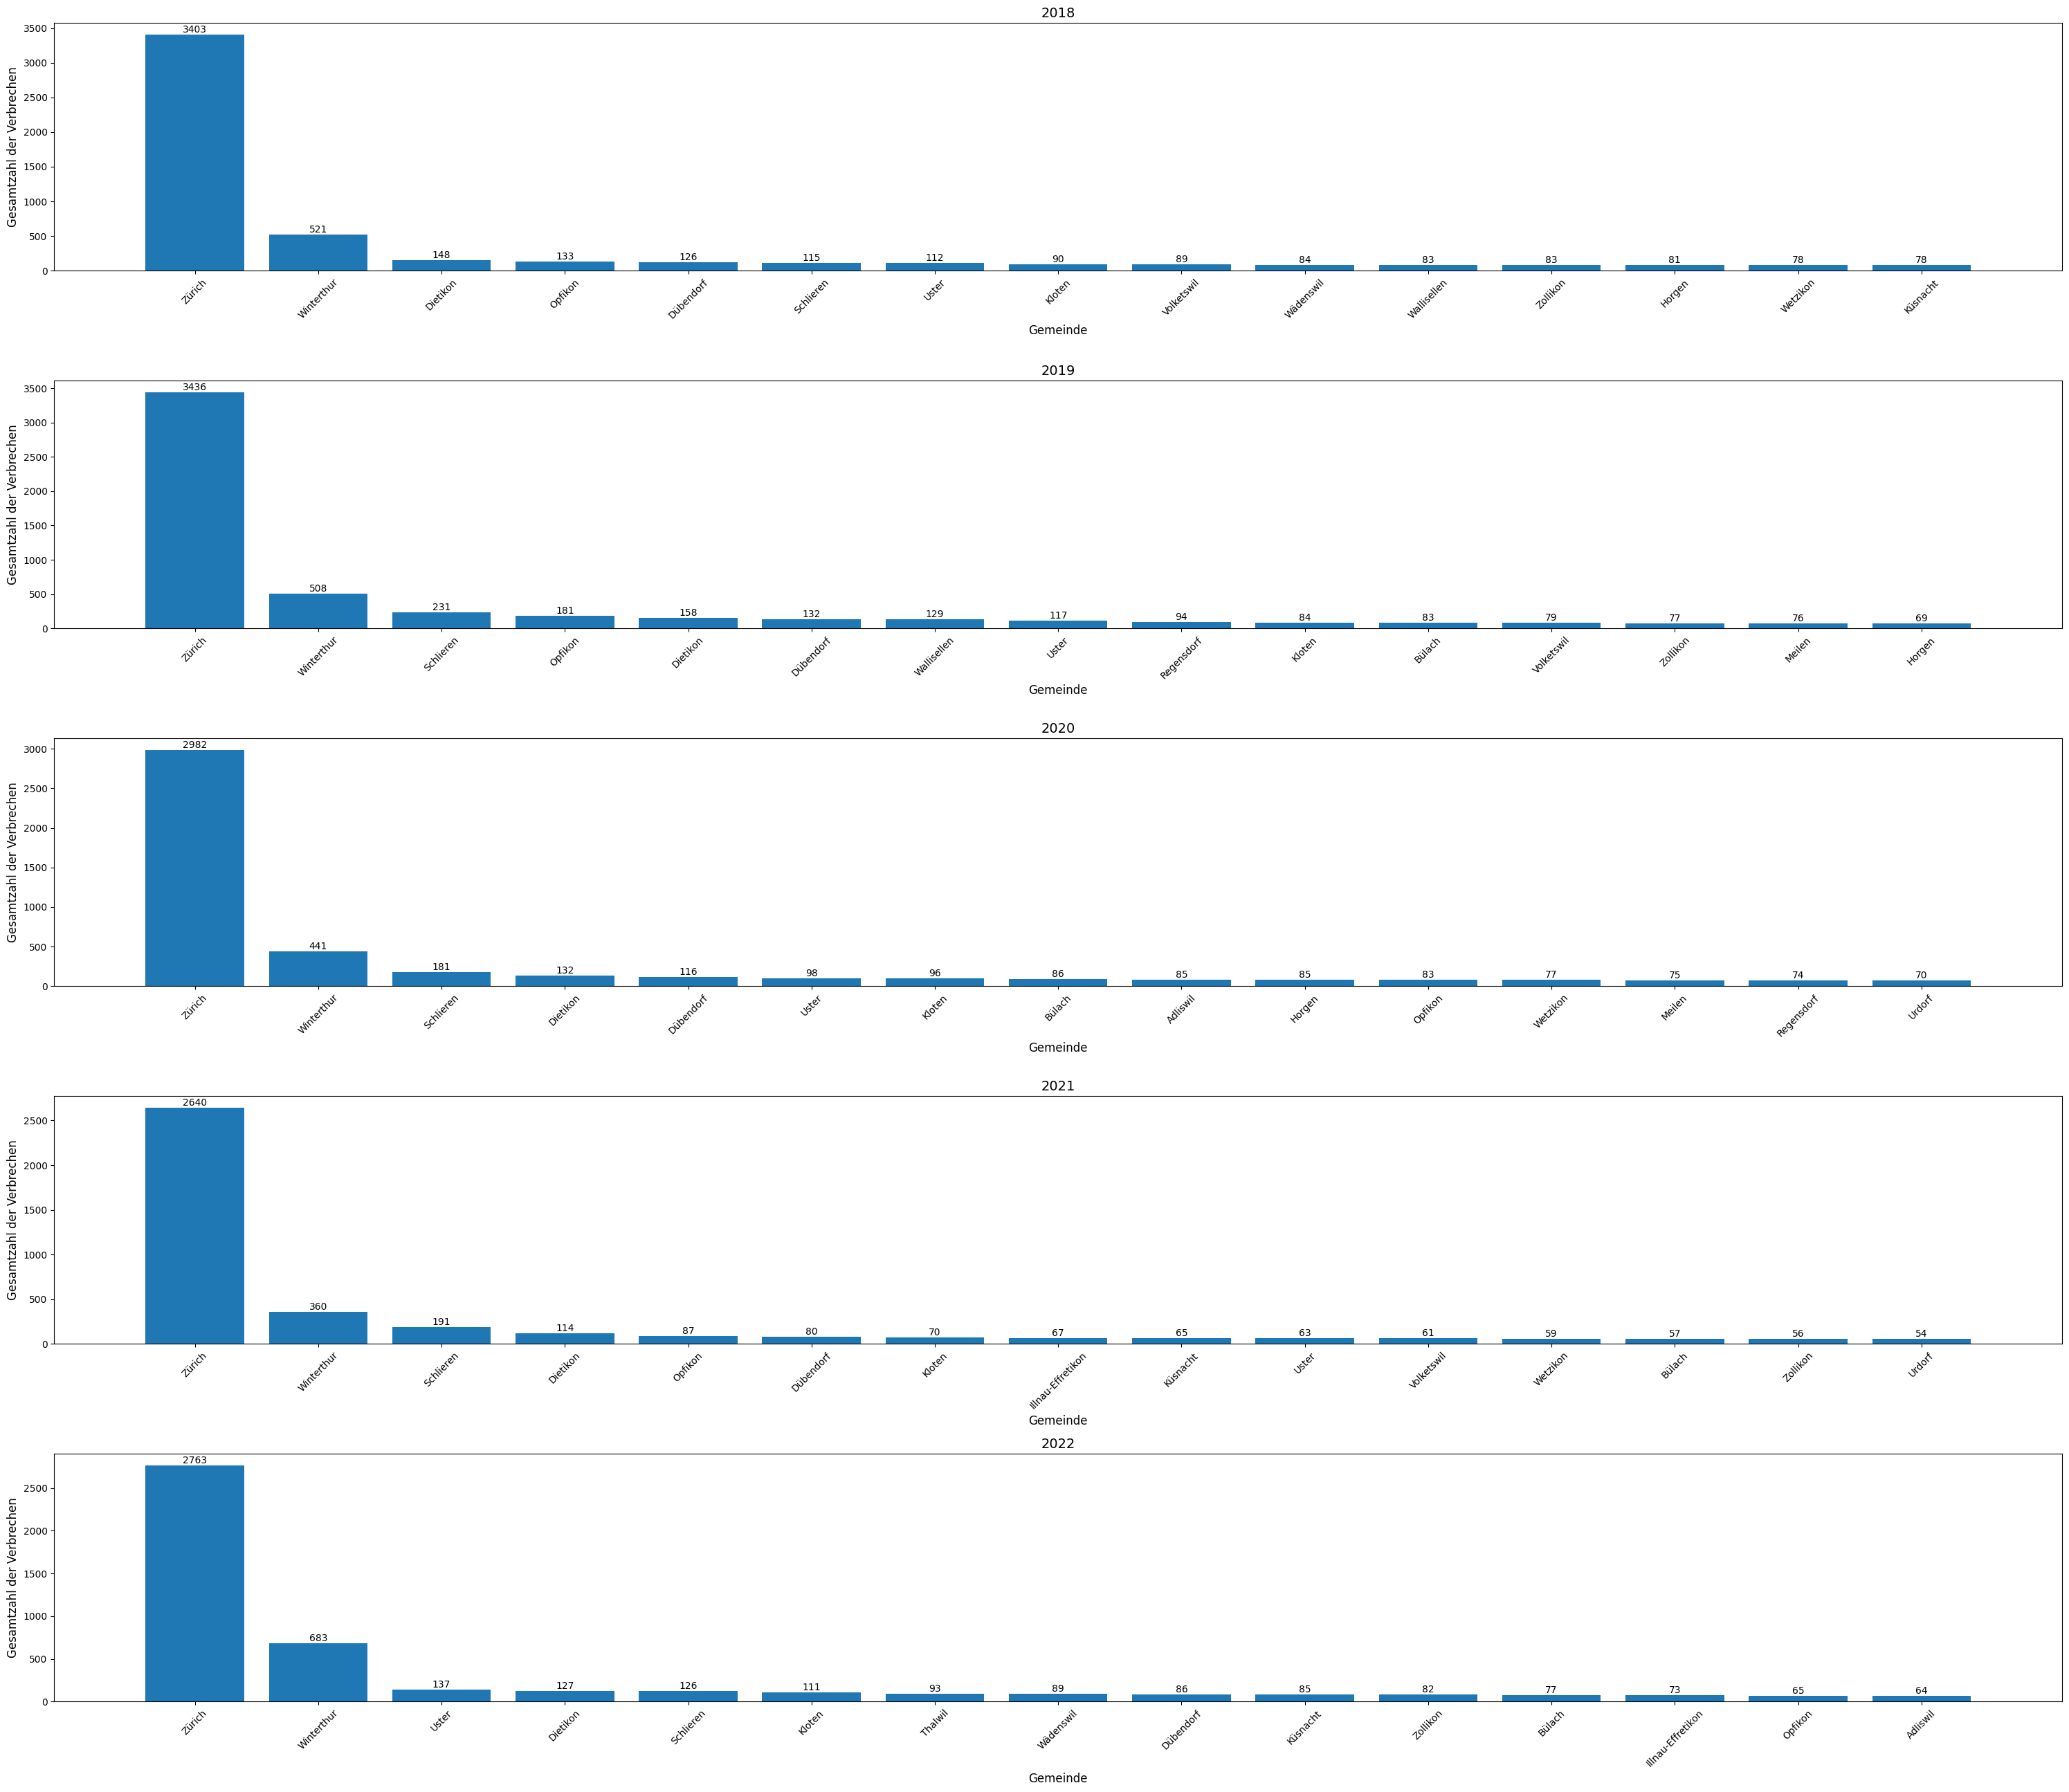

In [12]:
import matplotlib.pyplot as plt

df_last_5_years = df_unique[df_unique['Jahr'] >= df_unique['Jahr'].max() - 4]

df_sorted_by_crime = df_last_5_years.assign(
    total_crime=lambda x: x['Einbruchdiebstahl_Total'] + x['Einschleichdiebstahl_Total']
).sort_values(by='total_crime', ascending=False)


plt.figure(figsize=(30, 26))

for i, year in enumerate(range(df_sorted_by_crime['Jahr'].min(), df_sorted_by_crime['Jahr'].max() + 1)):
    plt.subplot(5, 1, i+1)
    data_year = df_sorted_by_crime[df_sorted_by_crime['Jahr'] == year].head(15)  # Wähle die Top-15-Gemeinden für jedes Jahr aus
    bars = plt.bar(data_year['Gemeindename'], data_year['total_crime'])
    plt.title(f'{year}', fontsize=14)
    plt.xlabel('Gemeinde', fontsize=12)
    plt.ylabel('Gesamtzahl der Verbrechen', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
   
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

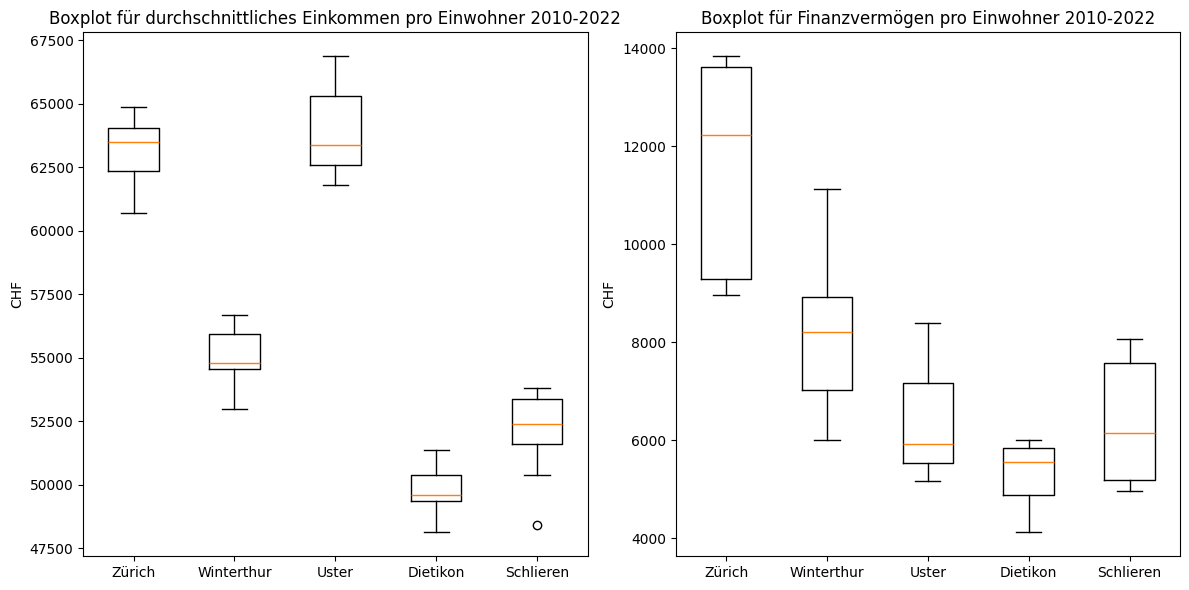

In [13]:
import matplotlib.pyplot as plt

top_5_gemeinden = ['Zürich', 'Winterthur', 'Uster', 'Dietikon', 'Schlieren']
df_2010_2022_top5 = df_unique[(df_unique['Gemeindename'].isin(top_5_gemeinden))]

# Einkommens- und Vermögensdaten extrahieren
income_data = [df_2010_2022_top5[df_2010_2022_top5['Gemeindename'] == gemeinde]['durchschnittliches_steuerbares_Einkommen_pro_Einwohner'] for gemeinde in top_5_gemeinden]
wealth_data = [df_2010_2022_top5[df_2010_2022_top5['Gemeindename'] == gemeinde]['Finanzvermoegen_pro_Einwohner'] for gemeinde in top_5_gemeinden]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.boxplot(income_data, labels=top_5_gemeinden)
plt.title('Boxplot für durchschnittliches Einkommen pro Einwohner 2010-2022')
plt.ylabel('CHF')

plt.subplot(1, 2, 2) 
plt.boxplot(wealth_data, labels=top_5_gemeinden)
plt.title('Boxplot für Finanzvermögen pro Einwohner 2010-2022')
plt.ylabel('CHF')

plt.tight_layout()
plt.show()

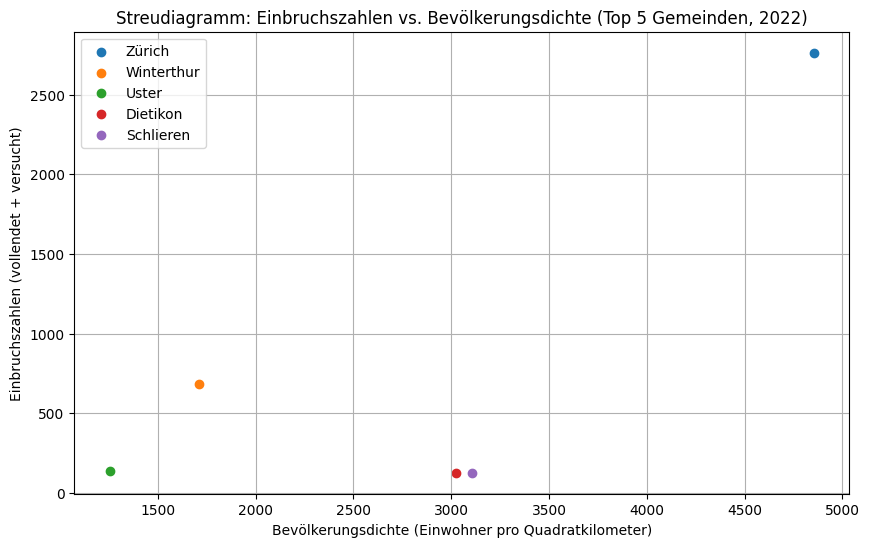

Die fünf Gemeinden mit der höchsten Bevölkerungsdichte im Jahr 2022 sind:
Zürich
Opfikon
Kilchberg
Thalwil
Oberengstringen


In [14]:
import matplotlib.pyplot as plt

top5_gemeinden = ['Zürich', 'Winterthur', 'Uster', 'Dietikon', 'Schlieren']
df_top5_2022 = df_unique[(df_unique['Gemeindename'].isin(top5_gemeinden)) & (df_unique['Jahr'] == 2022)]

# Gemeinden mit höchster Bevölkerungsdichte auswählen
highest_density = df_unique.nlargest(5, 'Einwohner_pro_Quadratkilometer')['Gemeindename']

plt.figure(figsize=(10, 6))
for gemeinde in top5_gemeinden:
    data = df_top5_2022[df_top5_2022['Gemeindename'] == gemeinde]
    plt.scatter(data['Einwohner_pro_Quadratkilometer'], data['Einbruchdiebstahl_Total'] + data['Einschleichdiebstahl_Total'], label=gemeinde)

plt.title('Streudiagramm: Einbruchszahlen vs. Bevölkerungsdichte (Top 5 Gemeinden, 2022)')
plt.xlabel('Bevölkerungsdichte (Einwohner pro Quadratkilometer)')
plt.ylabel('Einbruchszahlen (vollendet + versucht)')
plt.legend()
plt.grid(True)
plt.show()

highest_density_2022 = df_unique[df_unique['Jahr'] == 2022].nlargest(5, 'Einwohner_pro_Quadratkilometer')['Gemeindename']
print("Die fünf Gemeinden mit der höchsten Bevölkerungsdichte im Jahr 2022 sind:")
for gemeinde in highest_density_2022:
    print(gemeinde)

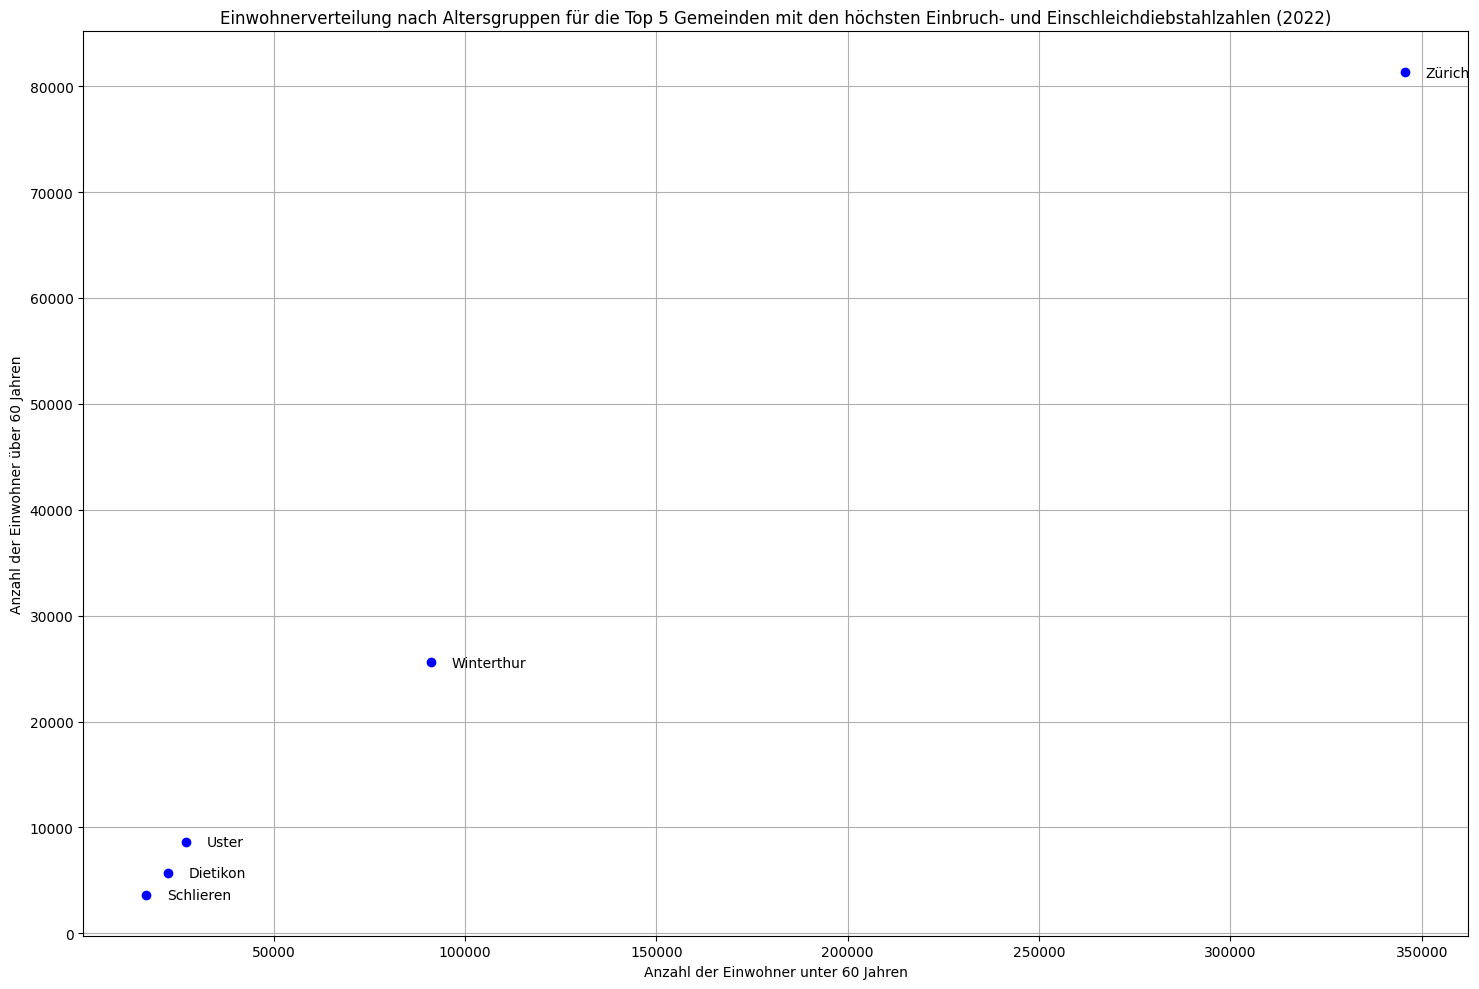

In [15]:
import matplotlib.pyplot as plt

df_2022 = df_unique[df_unique['Jahr'] == 2022]

top_5_communities = df_2022.nlargest(5, ['Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total'])
top_5_communities = top_5_communities[['Gemeindename', 'Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt', 
                                       'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt', 
                                       'Einwohner 60-74 Jahre alt', 'Einwohner 75-89 Jahre alt', 
                                       'Einwohner 90-104 Jahre alt']]

# Berechnung der Summe der Einwohner über 60 Jahre und unter 60 Jahren
top_5_communities['Einwohner über 60 Jahre'] = top_5_communities[['Einwohner 60-74 Jahre alt', 'Einwohner 75-89 Jahre alt', 
                                                                 'Einwohner 90-104 Jahre alt']].sum(axis=1)
top_5_communities['Einwohner unter 60 Jahre'] = top_5_communities[['Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt', 
                                                                   'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt']].sum(axis=1)

# Erstellen des Streudiagramms
plt.figure(figsize=(15, 10))
plt.scatter(top_5_communities['Einwohner unter 60 Jahre'], top_5_communities['Einwohner über 60 Jahre'], color='blue')

# Beschriftung der Punkte mit den Gemeindenamen
for i, txt in enumerate(top_5_communities['Gemeindename']):
    plt.annotate(txt, (top_5_communities['Einwohner unter 60 Jahre'].iloc[i], top_5_communities['Einwohner über 60 Jahre'].iloc[i]),
                 xytext=(15, -3), textcoords='offset points')  # Verschiebung der Labels um 5 Punkte nach rechts und oben

plt.xlabel('Anzahl der Einwohner unter 60 Jahren')
plt.ylabel('Anzahl der Einwohner über 60 Jahren')
plt.title('Einwohnerverteilung nach Altersgruppen für die Top 5 Gemeinden mit den höchsten Einbruch- und Einschleichdiebstahlzahlen (2022)')

plt.grid(True)
plt.tight_layout()
plt.show()


### Violin Plot

Die erstellte Visualisierung ermöglicht es, zu sehen, wie sich die Anzahl von Einbrüchen und Einschleichdiebstählen im Jahr 2022 in verschiedenen Einkommens- bzw. Vermögensgruppen verteilen. Dies kann Einblicke in mögliche Zusammenhänge zwischen Einkommen/Vermögen und Kriminalität liefern.

/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/2816631739.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Einkommensgruppe'] = df_2022.apply(income_group, axis=1)


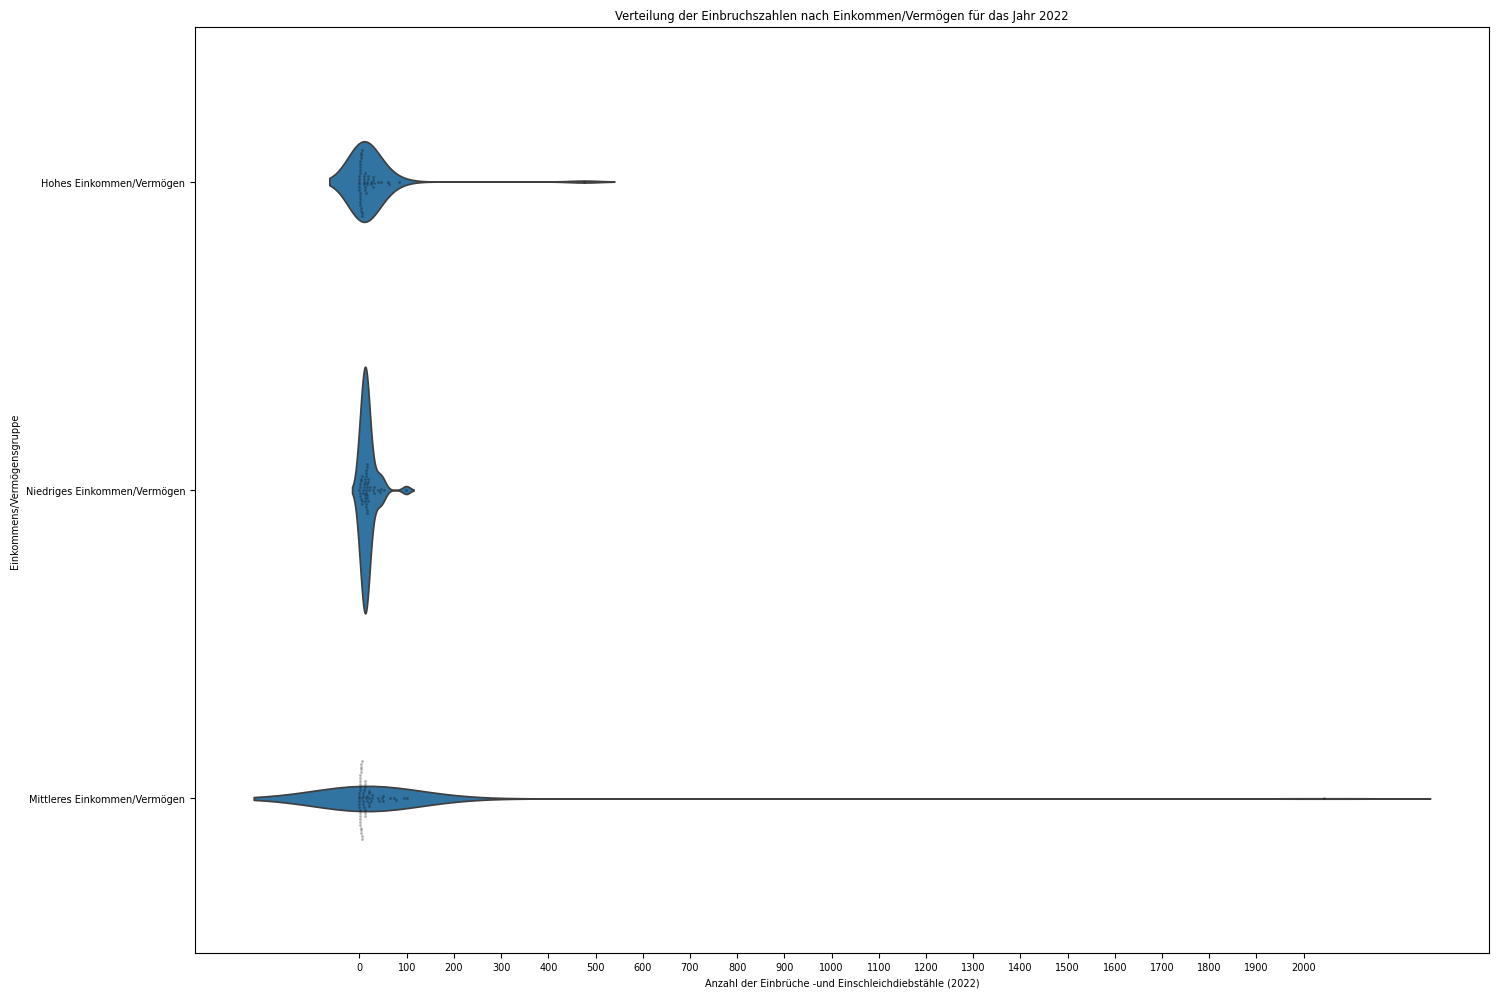

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  

df_2022 = df_unique[df_unique['Jahr'] == 2022]
quantiles = df_2022['Finanzvermoegen_pro_Einwohner'].quantile([0.3, 0.7])  # 30% und 70% Quantile

def income_group(row):
    if row['Finanzvermoegen_pro_Einwohner'] <= quantiles.iloc[0]:
        return 'Niedriges Einkommen/Vermögen'
    elif row['Finanzvermoegen_pro_Einwohner'] <= quantiles.iloc[1]:
        return 'Mittleres Einkommen/Vermögen'
    else:
        return 'Hohes Einkommen/Vermögen'

df_2022['Einkommensgruppe'] = df_2022.apply(income_group, axis=1)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 7}) 

sns.violinplot(x='Einbruchdiebstahl_Total', y='Einkommensgruppe', data=df_2022, inner=None)
sns.swarmplot(x='Einbruchdiebstahl_Total', y='Einkommensgruppe', data=df_2022, color='k', alpha=0.3, size=2)  

max_value = df_2022['Einbruchdiebstahl_Total'].max()
xticks = np.arange(0, max_value + 1, 100) 
plt.xticks(xticks)

plt.xlabel('Anzahl der Einbrüche -und Einschleichdiebstähle (2022)')
plt.ylabel('Einkommens/Vermögensgruppe')
plt.title('Verteilung der Einbruchszahlen nach Einkommen/Vermögen für das Jahr 2022')
plt.tight_layout()
plt.show()


### Visualisierte Korrelationsmatrix
Die Heatmap der Korrelationsmatrix ermöglicht es, auf einen Blick zu erkennen, welche Variablen stark miteinander korrelieren, welche schwach korrelieren und ob es positive oder negative Korrelationen gibt.

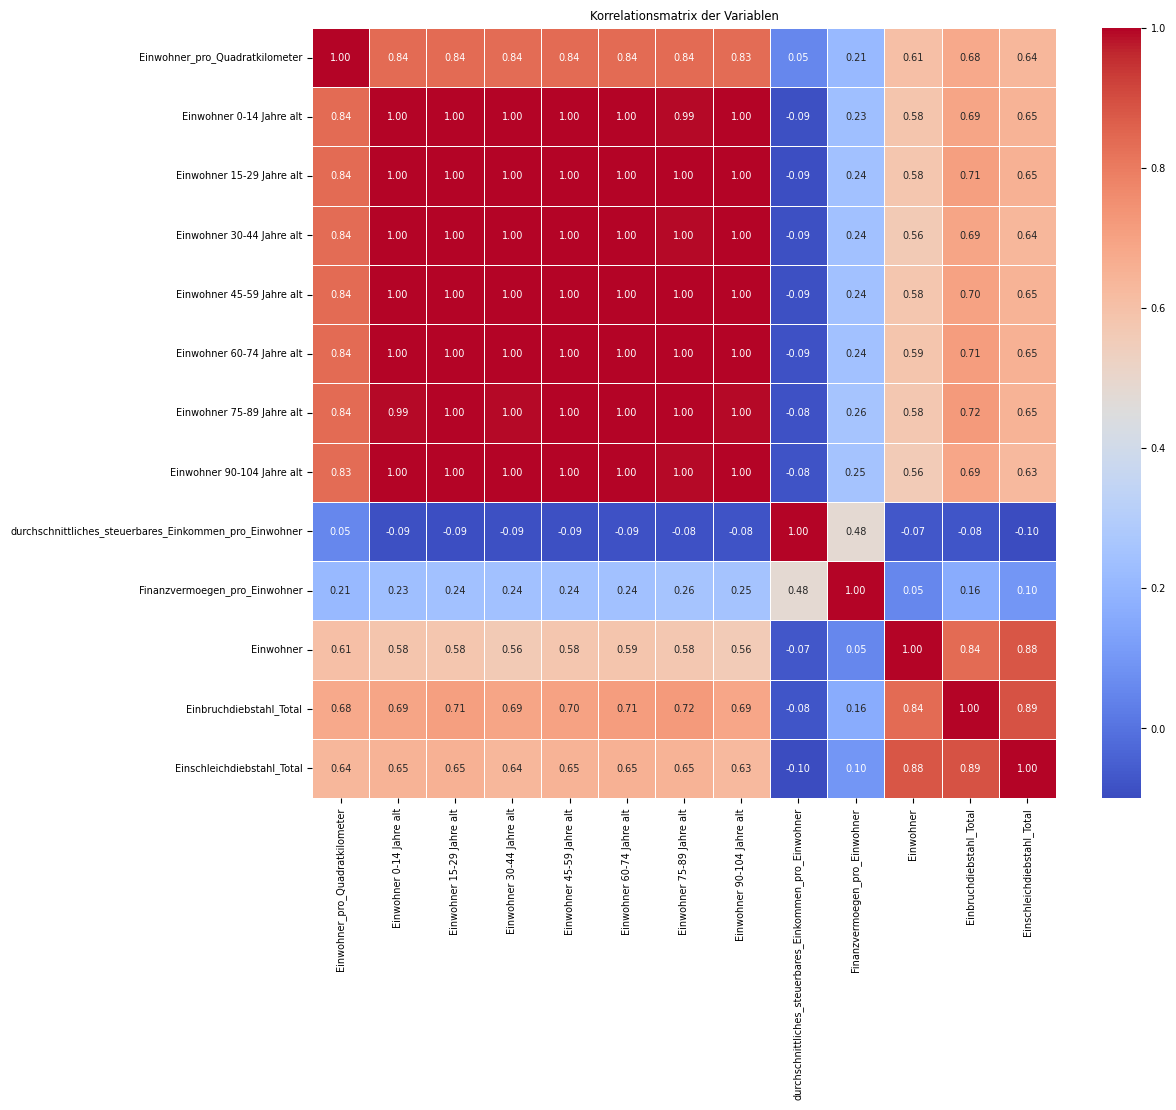

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Auswahl der numerischen Spalten
numeric_columns = df[['Einwohner_pro_Quadratkilometer', 'Einwohner 0-14 Jahre alt', 'Einwohner 15-29 Jahre alt',
                      'Einwohner 30-44 Jahre alt', 'Einwohner 45-59 Jahre alt', 'Einwohner 60-74 Jahre alt',
                      'Einwohner 75-89 Jahre alt', 'Einwohner 90-104 Jahre alt',
                      'durchschnittliches_steuerbares_Einkommen_pro_Einwohner', 'Finanzvermoegen_pro_Einwohner',
                      'Einwohner', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total',
                    ]]

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der Variablen')
plt.show()


1. Durchschnittliches steuerbares Einkommen pro Einwohner:
   - Korrelation von -0.08 mit Einbruchdiebstahl Total: Es besteht eine leichte negative Korrelation zwischen dem durchschnittlichen steuerbaren Einkommen pro Einwohner und der Gesamtzahl der Einbruchdiebstähle. Das bedeutet, dass Gemeinden mit höheren Einkommen tendenziell weniger Einbrüche haben.
   - Korrelation von -0.10 mit Einschleichdiebstahl Total: Die Korrelation ist schwach negativ, was darauf hinweist, dass es eine geringfügige Tendenz gibt, dass Gemeinden mit höherem Einkommen tendenziell weniger Einschleichdiebstähle haben.

2. Finanzvermögen pro Einwohner:
   - Korrelation von 0.16 mit Einbruchdiebstahl Total: Es besteht eine schwache positive Korrelation zwischen dem Finanzvermögen pro Einwohner und der Gesamtzahl der Einbruchdiebstähle. Dies bedeutet, dass Gemeinden mit höherem Finanzvermögen tendenziell etwas mehr Einbrüche haben könnten.
   - Korrelation von 0.10 mit Einschleichdiebstahl Total: Die Korrelation ist ebenfalls schwach positiv, was darauf hinweist, dass Gemeinden mit höherem Finanzvermögen tendenziell etwas mehr Einschleichdiebstähle haben könnten.

3. Einwohner:
   - Korrelation von 0.84 mit Einbruchdiebstahl Total: Es besteht eine starke positive Korrelation zwischen der Gesamteinwohnerzahl einer Gemeinde und der Gesamtzahl der Einbruchdiebstähle. Das bedeutet, dass Gemeinden mit einer höheren Bevölkerung tendenziell mehr Einbrüche haben.
   - Korrelation von 0.88 mit Einschleichdiebstahl Total: Die Korrelation ist ebenfalls stark positiv, was darauf hinweist, dass Gemeinden mit einer höheren Bevölkerung tendenziell mehr Einschleichdiebstähle haben.

### Lineare Regression

In dem bereitgestellten Code führen wir eine lineare Regressionsanalyse durch, um die Beziehung zwischen  dem durchschnittlichen steuerbaren Einkommen pro Einwohner und der Gesamtzahl der Einbruchdiebstähle im Jahr 2022.  Die lineare Regressionslinie gibt Aufschluss über die Richtung und Stärke dieser Beziehung.
Die Frage, die mit dieser Visualisierung beantwortet werden kann, ist, ob es einen Zusammenhang zwischen dem durchschnittlichen steuerpflichtigen Einkommen pro Einwohner und der Gesamtzahl der Einbruchsdiebstähle gibt, und wenn ja, welcher Art dieser Zusammenhang ist.

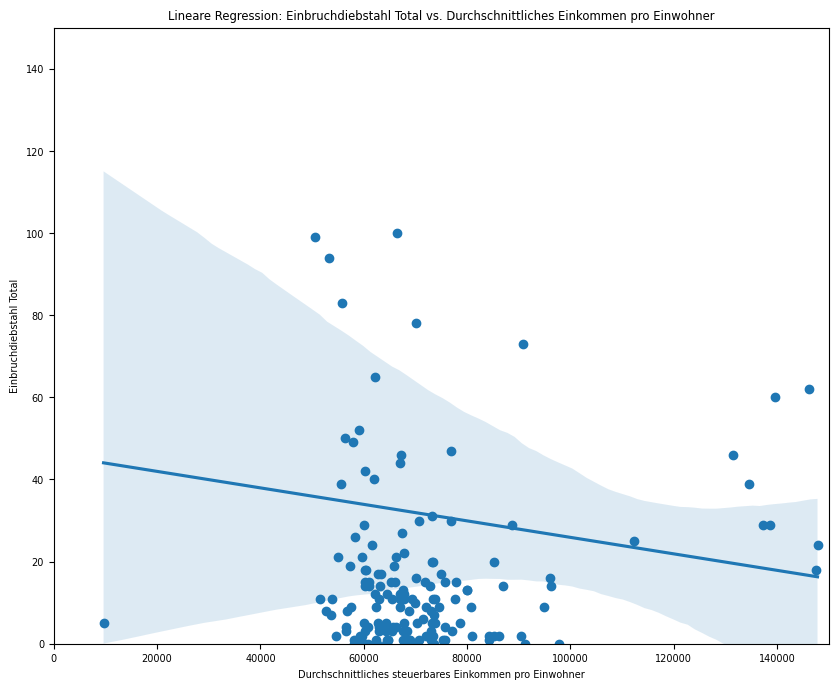

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_2022 = df_unique[df_unique['Jahr'] == 2022]
plt.figure(figsize=(10, 8))

plt.scatter(df_2022['durchschnittliches_steuerbares_Einkommen_pro_Einwohner'], df_2022['Einbruchdiebstahl_Total'])
sns.regplot(x='durchschnittliches_steuerbares_Einkommen_pro_Einwohner', y='Einbruchdiebstahl_Total', data=df_2022, scatter=False)

plt.xlabel('Durchschnittliches steuerbares Einkommen pro Einwohner')
plt.ylabel('Einbruchdiebstahl Total')
plt.title('Lineare Regression: Einbruchdiebstahl Total vs. Durchschnittliches Einkommen pro Einwohner')

plt.xlim(0, 150000) 
plt.ylim(0, 150)      
plt.show()

Man sieht eine negative lineare Beziehung zwischen den beiden Variablen. Bedeutet: je höher das durchschnittliche steuerpflichtige Einkommen pro Einwohner ist, desto weniger Einbruchdiebstähle treten möglicherweise auf. Dies könnte auf eine inverse Beziehung zwischen Wohlstand und Kriminalität hindeuten, da wohlmöglich mehr Möglichkeiten für Sicherheitsmassnahmen bestehen und dies unattraktiv für Täter ist.

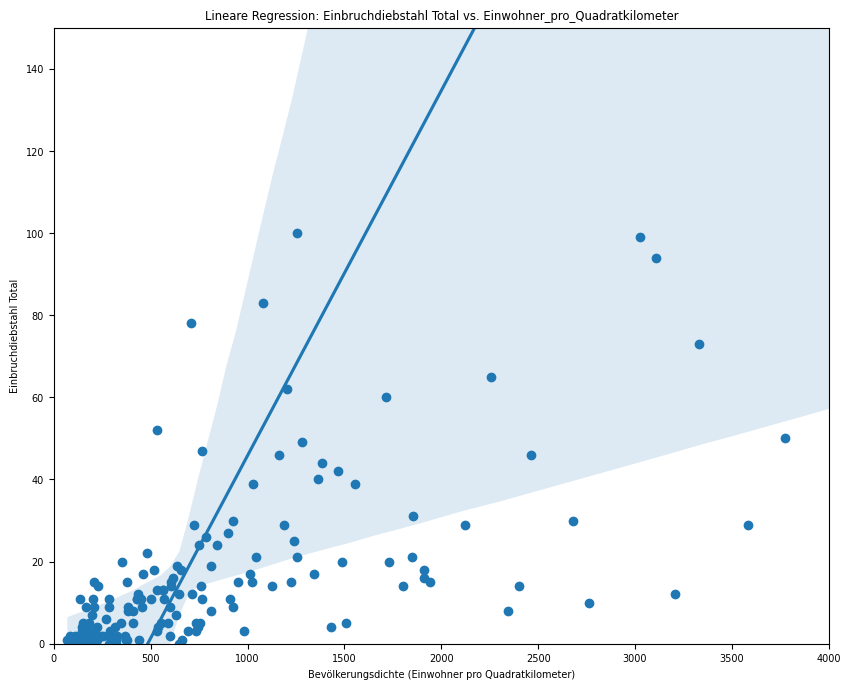

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

df_2022 = df_unique[df_unique['Jahr'] == 2022]
plt.figure(figsize=(10, 8))

plt.scatter(df_2022['Einwohner_pro_Quadratkilometer'], df_2022['Einbruchdiebstahl_Total'])
sns.regplot(x='Einwohner_pro_Quadratkilometer', y='Einbruchdiebstahl_Total', data=df_2022, scatter=False)

plt.xlabel('Bevölkerungsdichte (Einwohner pro Quadratkilometer)')
plt.ylabel('Einbruchdiebstahl Total')
plt.title('Lineare Regression: Einbruchdiebstahl Total vs. Einwohner_pro_Quadratkilometer')

plt.xlim(0, 4000) 
plt.ylim(0, 150)      
plt.show()

In diesem Fall suggeriert die steil nach oben zeigende Linie zwischen der Bevölkerungsdichte (Einwohner pro Quadratkilometer) und der Gesamtzahl der Einbruchdiebstähle, dass eine höhere Bevölkerungsdichte mit einer höheren Anzahl von Einbruchdiebstählen korreliert sein könnte.

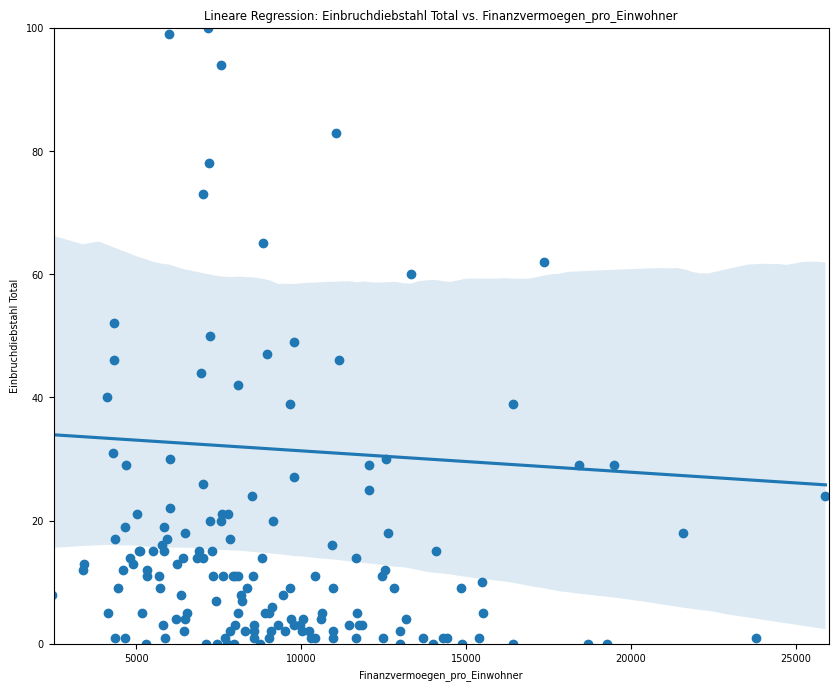

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

df_2022 = df_unique[df_unique['Jahr'] == 2022]
plt.figure(figsize=(10, 8))

plt.scatter(df_2022['Finanzvermoegen_pro_Einwohner'], df_2022['Einbruchdiebstahl_Total'])
sns.regplot(x='Finanzvermoegen_pro_Einwohner', y='Einbruchdiebstahl_Total', data=df_2022, scatter=False)

plt.xlabel('Finanzvermoegen_pro_Einwohner')
plt.ylabel('Einbruchdiebstahl Total')
plt.title('Lineare Regression: Einbruchdiebstahl Total vs. Finanzvermoegen_pro_Einwohner')

plt.xlim(2500, 26000) 
plt.ylim(0, 100)      
plt.show()

### KMeans-Clustering

Wir verwenden KMeans-Clustering, um Gemeinden anhand ihrer Merkmale zu gruppieren. Diese Visualisierung hilft uns zu verstehen, wie Gemeinden auf der Grundlage ihres Finanzvermögens pro Einwohner und der Gesamtzahl der Einbrüche und Einschleichdiebstähle im Jahr 2022 gruppiert sind. Sie gibt Aufschluss darüber, ob es erkennbare Muster oder Unterschiede zwischen den Gemeinden innerhalb dieser Cluster gibt. Wir berechnen zunächst den Silhouette-Score als Metrik zur Bewertung der Qualität der Clusterbildung des Modells. Er misst, wie ähnlich ein Objekt seinem eigenen Cluster (Kohäsion) im Vergleich zu anderen Clustern (Separation) ist und was die beste Anzahl für die Cluster ist.



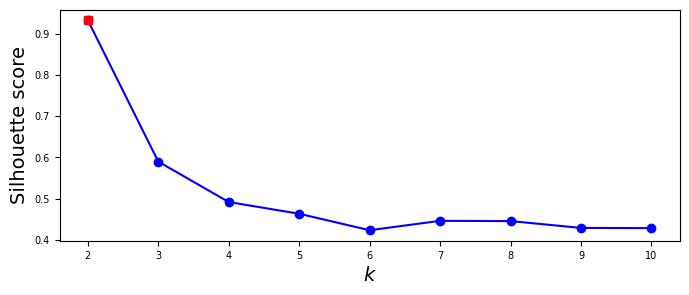

Best number of clusters based on Silhouette score: 2
Best Silhouette score: 0.9328907972483923


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

X = df_unique[['Finanzvermoegen_pro_Einwohner', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
k_range = range(2, 11)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_scaled) for k in k_range]
silhouette_scores = [silhouette_score(X_scaled, model.labels_) for model in kmeans_per_k]

best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

print("Best number of clusters based on Silhouette score:", best_k)
print("Best Silhouette score:", best_score)

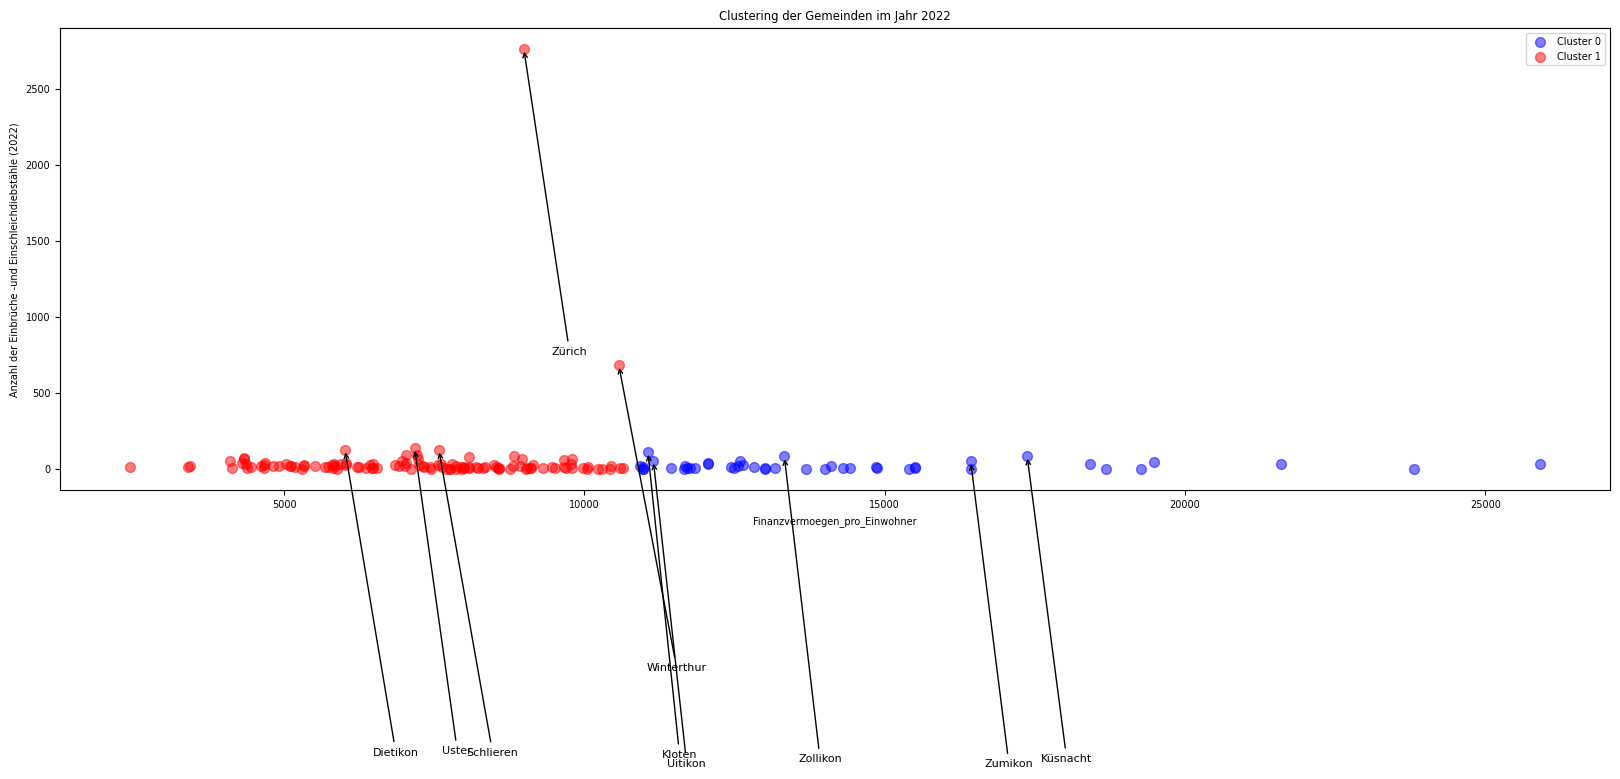

In [22]:
df_selected_year = df_unique[df_unique['Jahr'] == 2022]

X = df_selected_year[['Finanzvermoegen_pro_Einwohner', 
                      'Einbruchdiebstahl_Total', 
                      'Einschleichdiebstahl_Total']].values

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_

plt.figure(figsize=(20,6))

plt.scatter(X[cluster_labels == 0, 0], X[cluster_labels == 0, 1] + X[cluster_labels == 0, 2], 
            c='blue', label='Cluster 0', s=50, alpha=0.5)

plt.scatter(X[cluster_labels == 1, 0], X[cluster_labels == 1, 1] + X[cluster_labels == 1, 2], 
            c='red', label='Cluster 1', s=50, alpha=0.5)

top_5_cluster_0 = df_selected_year[cluster_labels == 0].nlargest(5, 'Einbruchdiebstahl_Total')
for index, row in top_5_cluster_0.iterrows():
    plt.annotate(row['Gemeindename'], (row['Finanzvermoegen_pro_Einwohner'], row['Einbruchdiebstahl_Total'] + row['Einschleichdiebstahl_Total']), 
                 xytext=(10, -220), textcoords='offset points', fontsize=8,
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

top_5_cluster_1 = df_selected_year[cluster_labels == 1].nlargest(5, 'Einbruchdiebstahl_Total')
for index, row in top_5_cluster_1.iterrows():
    plt.annotate(row['Gemeindename'], (row['Finanzvermoegen_pro_Einwohner'], row['Einbruchdiebstahl_Total'] + row['Einschleichdiebstahl_Total']), 
                 xytext=(20, -220), textcoords='offset points', fontsize=8,
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Finanzvermoegen_pro_Einwohner')
plt.ylabel('Anzahl der Einbrüche -und Einschleichdiebstähle (2022)')
plt.title('Clustering der Gemeinden im Jahr 2022')

plt.legend()
plt.show()

In [23]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
pd.set_option('display.max_rows', None)

cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Vermoegen_pro_Einwohner': df_selected_year['Finanzvermoegen_pro_Einwohner']})

cluster_1_df = cluster_df[cluster_df['Cluster'] == 1]
cluster_1_data = cluster_1_df.values.tolist()
print("Cluster 1:")
print(tabulate(cluster_1_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle','Vermoegen_pro_Einwohner'], tablefmt='pretty', showindex=True))

Cluster 1:
+-----+----------------------+---------+--------------------------------------------+-------------------------+
|     |       Gemeinde       | Cluster | Total Einbrüche -und Einschleichdiebstähle | Vermoegen_pro_Einwohner |
+-----+----------------------+---------+--------------------------------------------+-------------------------+
|  0  |      Affoltern       |    1    |                    40.0                    |         4684.0          |
|  1  |      Bonstetten      |    1    |                    13.0                    |         5176.0          |
|  2  |       Hedingen       |    1    |                    8.0                     |         9038.0          |
|  3  |        Knonau        |    1    |                    1.0                     |         7695.0          |
|  4  |     Maschwanden      |    1    |                    0.0                     |         5305.0          |
|  5  |    Mettmenstetten    |    1    |                    12.0                    |        

/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/1205712800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']


In [24]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Finanzvermoegen_pro_Einwohner': df_selected_year['Finanzvermoegen_pro_Einwohner']})


cluster_1_df = cluster_df[cluster_df['Cluster'] == 1]
sorted_df = cluster_1_df.sort_values(by='Total Einbrüche -und Einschleichdiebstähle', ascending=False)

top_5 = sorted_df.head(5)
top_5_data = top_5.values.tolist()

print(tabulate(top_5_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle', 'Finanzvermoegen_pro_Einwohner'], tablefmt='pretty', showindex=False))


+------------+---------+--------------------------------------------+-------------------------------+
|  Gemeinde  | Cluster | Total Einbrüche -und Einschleichdiebstähle | Finanzvermoegen_pro_Einwohner |
+------------+---------+--------------------------------------------+-------------------------------+
|   Zürich   |    1    |                   2763.0                   |            8990.0             |
| Winterthur |    1    |                   683.0                    |            10571.0            |
|   Uster    |    1    |                   137.0                    |            7172.0             |
|  Dietikon  |    1    |                   127.0                    |            6012.0             |
| Schlieren  |    1    |                   126.0                    |            7575.0             |
+------------+---------+--------------------------------------------+-------------------------------+


/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/2362419174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']


In [25]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
pd.set_option('display.max_rows', None)

cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Vermoegen_pro_Einwohner': df_selected_year['Finanzvermoegen_pro_Einwohner']})

cluster_1_df = cluster_df[cluster_df['Cluster'] == 0]
cluster_1_data = cluster_1_df.values.tolist()

print("Cluster 0:")
print(tabulate(cluster_1_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle','Vermoegen_pro_Einwohner'], tablefmt='pretty', showindex=True))


Cluster 0:
+----+-----------------+---------+--------------------------------------------+-------------------------+
|    |    Gemeinde     | Cluster | Total Einbrüche -und Einschleichdiebstähle | Vermoegen_pro_Einwohner |
+----+-----------------+---------+--------------------------------------------+-------------------------+
| 0  |     Aeugst      |    0    |                    2.0                     |         13013.0         |
| 1  |     Hausen      |    0    |                    15.0                    |         12828.0         |
| 2  |     Kappel      |    0    |                    3.0                     |         11845.0         |
| 3  |   Rifferswil    |    0    |                    1.0                     |         13694.0         |
| 4  |     Benken      |    0    |                    6.0                     |         11699.0         |
| 5  |      Berg       |    0    |                    0.0                     |         19269.0         |
| 6  |      Buch       |    0    | 

/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/3555893434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']


In [26]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Finanzvermoegen_pro_Einwohner': df_selected_year['Finanzvermoegen_pro_Einwohner']})

cluster_0_df = cluster_df[cluster_df['Cluster'] == 0]
sorted_df = cluster_0_df.sort_values(by='Total Einbrüche -und Einschleichdiebstähle', ascending=False)

top_5 = sorted_df.head(5)
top_5_data = top_5.values.tolist()

print(tabulate(top_5_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle', 'Finanzvermoegen_pro_Einwohner'], tablefmt='pretty', showindex=False))


+-------------+---------+--------------------------------------------+-------------------------------+
|  Gemeinde   | Cluster | Total Einbrüche -und Einschleichdiebstähle | Finanzvermoegen_pro_Einwohner |
+-------------+---------+--------------------------------------------+-------------------------------+
|   Kloten    |    0    |                   111.0                    |            11056.0            |
|  Küsnacht   |    0    |                    85.0                    |            17370.0            |
|  Zollikon   |    0    |                    82.0                    |            13327.0            |
|   Uitikon   |    0    |                    53.0                    |            11147.0            |
| Wallisellen |    0    |                    52.0                    |            12591.0            |
+-------------+---------+--------------------------------------------+-------------------------------+


/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/2881064503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']


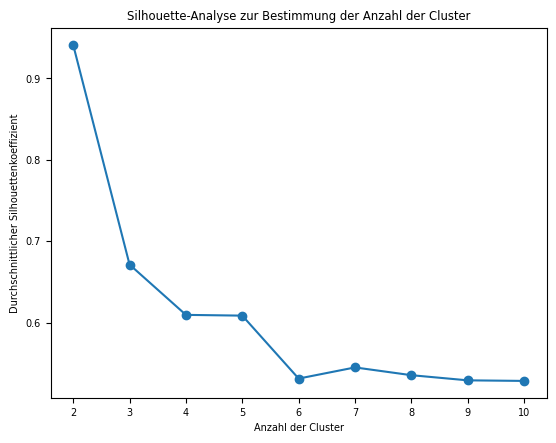

Optimale Anzahl von Clustern basierend auf der Silhouette-Analyse: 2


In [27]:
X = df_unique[['Einwohner_pro_Quadratkilometer', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel('Anzahl der Cluster')
plt.ylabel('Durchschnittlicher Silhouettenkoeffizient')
plt.title('Silhouette-Analyse zur Bestimmung der Anzahl der Cluster')
plt.show()

optimal_cluster_index = np.argmax(silhouette_scores)
optimal_num_clusters = clusters_range[optimal_cluster_index]
print("Optimale Anzahl von Clustern basierend auf der Silhouette-Analyse:", optimal_num_clusters)

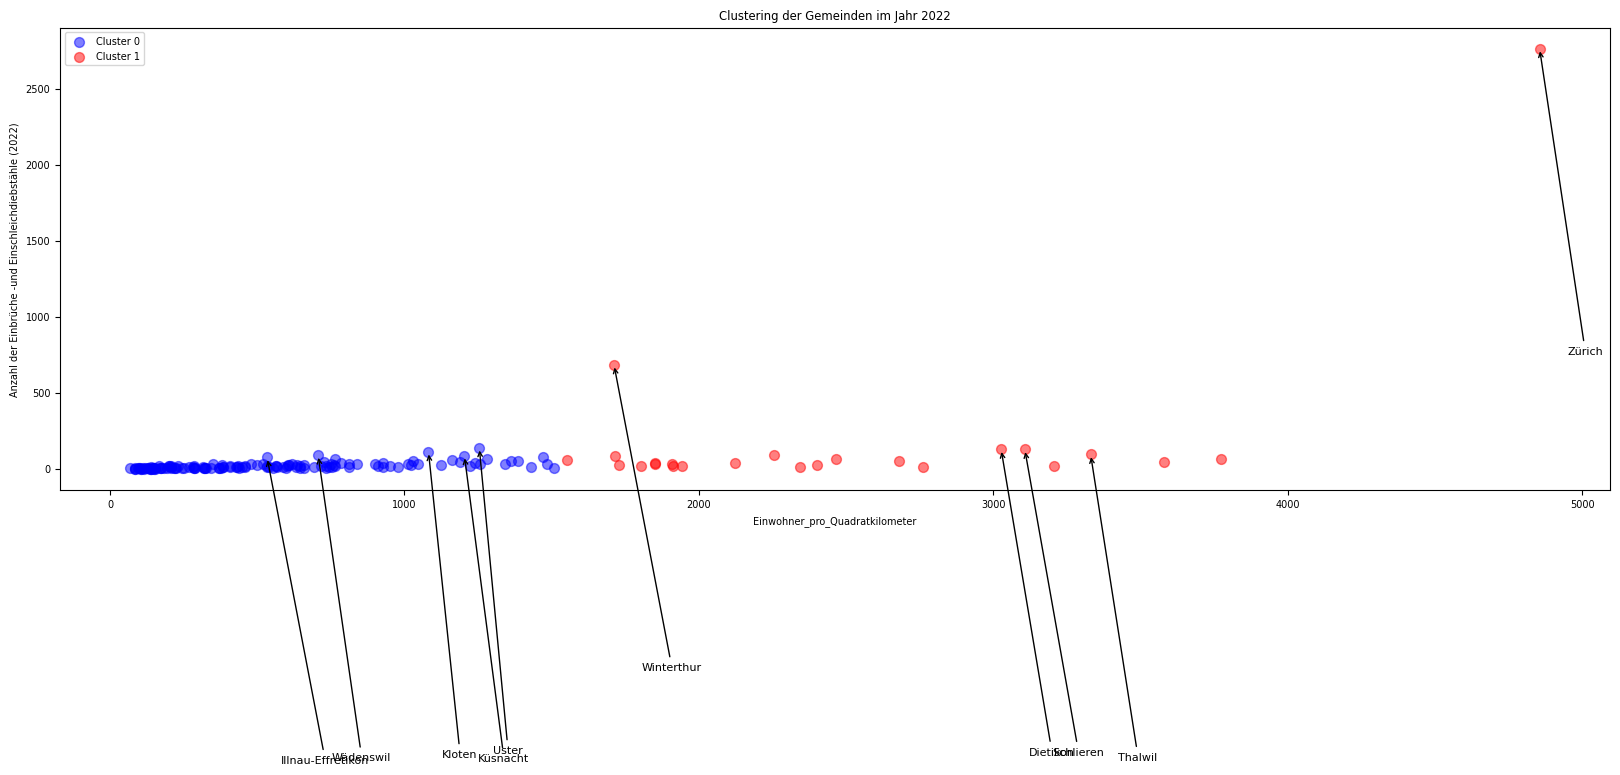

In [28]:
df_selected_year = df_unique[df_unique['Jahr'] == 2022]

X = df_selected_year[['Einwohner_pro_Quadratkilometer', 
                      'Einbruchdiebstahl_Total', 
                      'Einschleichdiebstahl_Total']].values

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_

plt.figure(figsize=(20,6))

plt.scatter(X[cluster_labels == 0, 0], X[cluster_labels == 0, 1] + X[cluster_labels == 0, 2], 
            c='blue', label='Cluster 0', s=50, alpha=0.5)

plt.scatter(X[cluster_labels == 1, 0], X[cluster_labels == 1, 1] + X[cluster_labels == 1, 2], 
            c='red', label='Cluster 1', s=50, alpha=0.5)

top_5_cluster_0 = df_selected_year[cluster_labels == 0].nlargest(5, 'Einbruchdiebstahl_Total')
for index, row in top_5_cluster_0.iterrows():
    plt.annotate(row['Gemeindename'], (row['Einwohner_pro_Quadratkilometer'], row['Einbruchdiebstahl_Total'] + row['Einschleichdiebstahl_Total']), 
                 xytext=(10, -220), textcoords='offset points', fontsize=8,
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

top_5_cluster_1 = df_selected_year[cluster_labels == 1].nlargest(5, 'Einbruchdiebstahl_Total')
for index, row in top_5_cluster_1.iterrows():
    plt.annotate(row['Gemeindename'], (row['Einwohner_pro_Quadratkilometer'], row['Einbruchdiebstahl_Total'] + row['Einschleichdiebstahl_Total']), 
                 xytext=(20, -220), textcoords='offset points', fontsize=8,
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Einwohner_pro_Quadratkilometer')
plt.ylabel('Anzahl der Einbrüche -und Einschleichdiebstähle (2022)')
plt.title('Clustering der Gemeinden im Jahr 2022')

plt.legend()
plt.show()


In [29]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']

cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Einwohner_pro_Quadratkilometer': df_selected_year['Einwohner_pro_Quadratkilometer']})

cluster_0_df = cluster_df[cluster_df['Cluster'] == 0]
sorted_df = cluster_0_df.sort_values(by='Total Einbrüche -und Einschleichdiebstähle', ascending=False)

top_5 = sorted_df.head(5)
top_5_data = top_5.values.tolist()

print(tabulate(top_5_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle', 'Einwohner_pro_Quadratkilometer'], tablefmt='pretty', showindex=False))

+-----------+---------+--------------------------------------------+--------------------------------+
| Gemeinde  | Cluster | Total Einbrüche -und Einschleichdiebstähle | Einwohner_pro_Quadratkilometer |
+-----------+---------+--------------------------------------------+--------------------------------+
|   Uster   |    0    |                   137.0                    |             1254.3             |
|  Kloten   |    0    |                   111.0                    |             1081.7             |
| Wädenswil |    0    |                    89.0                    |             706.9              |
| Küsnacht  |    0    |                    85.0                    |             1203.7             |
|  Bülach   |    0    |                    77.0                    |             1469.1             |
+-----------+---------+--------------------------------------------+--------------------------------+


/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/1647008171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']


In [30]:
df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
cluster_df = pd.DataFrame({'Gemeinde': df_selected_year['Gemeindename'], 
                           'Cluster': cluster_labels,
                           'Total Einbrüche -und Einschleichdiebstähle': df_selected_year['Total Einbrüche -und Einschleichdiebstähle'],
                           'Einwohner_pro_Quadratkilometer': df_selected_year['Einwohner_pro_Quadratkilometer']})

cluster_0_df = cluster_df[cluster_df['Cluster'] == 1]
sorted_df = cluster_0_df.sort_values(by='Total Einbrüche -und Einschleichdiebstähle', ascending=False)

top_5 = sorted_df.head(5)
top_5_data = top_5.values.tolist()

print(tabulate(top_5_data, headers=['Gemeinde', 'Cluster', 'Total Einbrüche -und Einschleichdiebstähle', 'Einwohner_pro_Quadratkilometer'], tablefmt='pretty', showindex=False))

+------------+---------+--------------------------------------------+--------------------------------+
|  Gemeinde  | Cluster | Total Einbrüche -und Einschleichdiebstähle | Einwohner_pro_Quadratkilometer |
+------------+---------+--------------------------------------------+--------------------------------+
|   Zürich   |    1    |                   2763.0                   |             4855.4             |
| Winterthur |    1    |                   683.0                    |             1711.8             |
|  Dietikon  |    1    |                   127.0                    |             3026.6             |
| Schlieren  |    1    |                   126.0                    |             3107.0             |
|  Thalwil   |    1    |                    93.0                    |             3330.6             |
+------------+---------+--------------------------------------------+--------------------------------+


/var/folders/lt/9lkssqds44vcn4hwlh7dd2wc0000gn/T/ipykernel_14004/1321458047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_year['Total Einbrüche -und Einschleichdiebstähle'] = df_selected_year['Einbruchdiebstahl_Total'] + df_selected_year['Einschleichdiebstahl_Total']
